In [26]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset:

In [27]:
data_size = 1_000_000
data_gen = SingleRandomRing(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=True)
data_gen.noise_delta

{'mse_loss': {'mean': 0.003376128152012825, 'std': 0.0009832163341343403},
 'l1_loss': {'mean': 0.01787707582116127, 'std': 0.00468863220885396}}

[[1.5000000e+01 1.5000000e+01 8.3876591e+00 1.4315487e+00 3.1674621e+00
  3.3191517e-01]
 [1.4000000e+01 1.4000000e+01 6.1373792e+00 8.7404770e-01 5.5926185e+00
  3.6356446e-01]
 [1.3000000e+01 1.3000000e+01 6.9882064e+00 1.2194709e+00 3.2033725e+00
  1.5067139e-01]
 ...
 [1.0000000e+01 1.4000000e+01 6.4280725e+00 1.5940459e+00 3.2714841e+00
  2.5851130e-03]
 [8.0000000e+00 1.5000000e+01 8.6333265e+00 1.1703691e+00 1.9037338e+00
  5.9980094e-02]
 [8.0000000e+00 1.3000000e+01 7.0250688e+00 1.3734868e+00 5.5027456e+00
  4.4630238e-01]]
[[0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.54135038e-01
  3.35293582e-01 4.40674397e-01]
 [0.00000000e+00 8.57142857e-01 8.57142857e-01 ... 7.92267925e-01
  6.48460237e-01 5.28720883e-01]
 [0.00000000e+00 7.14285714e-01 7.14285714e-01 ... 2.59930097e-01
  1.53930575e-01 9.08082320e-02]
 ...
 [0.00000000e+00 2.85714286e-01 8.57142857e-01 ... 2.71101129e-01
  2.69714787e-03 2.67314571e-05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 9.180242

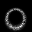

In [28]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray((imgs[0].reshape((32, 32)) * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [122]:
# load generator
generator = HalfDGBaNConv17()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/SingleRandomRing/Adam_mse_loss_0/HalfDGBaNConv17_no_activation_function/HalfDGBaNConv17_no_activation_function_4.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

HalfDGBaNConv17(
  (linear_1): LinearReparameterization()
  (linear_2): LinearReparameterization()
  (linear_3): LinearReparameterization()
  (linear_4): LinearReparameterization()
  (linear_5): LinearReparameterization()
  (linear_6): Linear(in_features=896, out_features=1024, bias=True)
  (conv_layers): Sequential(
    (0): BottleNeck(
      (0): Sequential(
        (0): ResidualAdd(
          (block): Sequential(
            (0): ConvNormAct(
              (0): ConvTranspose2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): ConvNormAct(
              (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): ConvNormAct(
              (0): ConvTranspose2d(64, 

0.005645019
0.033217777
0.0061735474


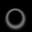

In [123]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))
 
print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))
Image.fromarray(abs(y_pred.reshape((32, 32)) * 255).astype(np.uint8))

In [124]:
n_samples = 500

# getting the predictions for this feature
pred_rings = torch.zeros((n_samples, 1024), dtype=torch.float, device='cpu')
X = torch.Tensor(transformed_features[:1])
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X)[0].squeeze()

pred_rings = pred_rings.detach().numpy().reshape((n_samples, 32, 32))

pred_ring = pred_rings.mean(axis=0) * 255
true_img = data_gen.ring_from_features(*features[0])
true_ring = true_img * 255

In [125]:
n_samples = data_gen.kernel.shape[0] // 20

# getting the predictions for this feature
true_prob_samples = torch.zeros((n_samples, 32, 32))
for j in range(n_samples):
    true_prob_samples[j] += true_img * data_gen.kernel[j].reshape((32, 32))

true_prob_samples = true_prob_samples.numpy()

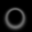

In [126]:
# predicted gaussian ring
Image.fromarray(abs(pred_ring).astype(np.uint8))

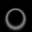

In [127]:
# true gaussian ring
Image.fromarray(true_ring.numpy().astype(np.uint8))

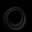

In [128]:
# difference between the rings
Image.fromarray(np.abs(true_ring.numpy() - pred_ring).astype(np.uint8))

In [129]:
# MSE error
((pred_ring / pred_ring.max() - true_ring.numpy() / true_ring.numpy().max())**2).mean()

0.011136822

(27, 19)


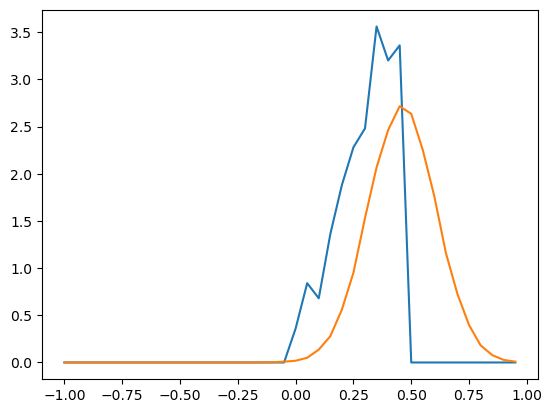

In [147]:
# getting the distribution for one pmt
pmt = (np.random.randint(32), np.random.randint(32))
while true_ring[pmt] < 0.2 * 255:
    pmt = (np.random.randint(32), np.random.randint(32))
print(pmt)

hist_width = 0.05

# predictited distribution
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_prob_samples[:, pmt[0], pmt[1]])
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()